# **Finding Lane Lines on the Road** 
***
Random text...
---
The steps for the project is:
1.    Camera calibration
2.    Distortion correction
3.    Color/gradient threshold
4.    Perspective transform

Thereafter:

-    Detect lane lines
-    Determine the lane curvature



**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

# **Calibrating the camera** 
***
The camera is calibrated by using the chessboard images in the camera_cal folder.
---
The steps of calibration are:
* Find chessboard corners
* Calibrate camera based on 


---

In [1]:
# Import some useful packages

import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
import pickle

%matplotlib inline

In [6]:
# Find the chessboard corners

# define number of rows and columns in calibration images
nx = 9
ny = 6

# arrays to store object points and image points of all images
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# prepare object points
objp = np.zeros((nx*ny,3),np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# create list of calibration images
testImages = glob.glob("camera_cal/calibration*.jpg")

# Step through the list and search for chessboard corners
for idx, fname in enumerate(testImages):
    # Load image
    img = mpimg.imread(fname)
    # Gray scale (BGR since using opencv load function)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)

        '''
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)
        '''

#cv2.destroyAllWindows()


['camera_cal/calibration14.jpg', 'camera_cal/calibration19.jpg', 'camera_cal/calibration3.jpg', 'camera_cal/calibration15.jpg', 'camera_cal/calibration4.jpg', 'camera_cal/calibration10.jpg', 'camera_cal/calibration6.jpg', 'camera_cal/calibration12.jpg', 'camera_cal/calibration17.jpg', 'camera_cal/calibration2_undist.jpg', 'camera_cal/calibration8.jpg', 'camera_cal/calibration13.jpg', 'camera_cal/calibration20.jpg', 'camera_cal/calibration11.jpg', 'camera_cal/calibration1.jpg', 'camera_cal/calibration5.jpg', 'camera_cal/calibration9.jpg', 'camera_cal/calibration2.jpg', 'camera_cal/calibration18.jpg', 'camera_cal/calibration7.jpg', 'camera_cal/calibration16.jpg']


In [7]:
# Calibrate camera


# Test undistortion on an image
img = mpimg.imread('camera_cal/calibration2.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,img_size,None,None)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("camera_cal/calibration_dist_pickle.p", "wb"))


# **Undistorting image**

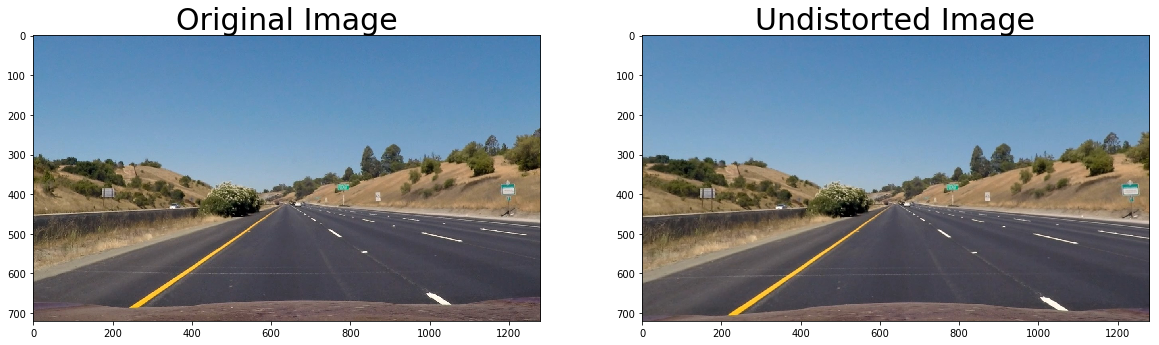

In [8]:
# Undistort image

# Load camera calibration
dist_pickle = pickle.load(open("camera_cal/calibration_dist_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Load image for distortion
img = mpimg.imread('test_images/straight_lines1.jpg')

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('test_images/straight_lines1_undst.jpg',dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)


# **Color/gradient thresholding**
***
To determine where the lane markings are we will need to make sure to find them properly, being able to detect all kinds of lane markings and in all kinds of situations.
---

Steps considered:
- 
- 


In [21]:
# Functions to be used for thresholding

# Function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    
    # 1) Convert to grayscale
    #gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobelxy = cv2.Sobel(img, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    else:
        sobelxy = cv2.Sobel(img, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    absSobel = np.absolute(sobelxy)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    bitSobel = np.int8(255*absSobel/np.max(absSobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    sxbinary = np.zeros_like(bitSobel)
    sxbinary[(bitSobel >= thresh[0]) & (bitSobel <= thresh[1])] = 1
    return sxbinary

# Function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # 1) Convert to grayscale
    #gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=sobel_kernel)
    # 3) Calculate the magnitude
    sobel_mag = np.sqrt(np.square(sobelx)+np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    intSobel = np.int8(255*sobel_mag/np.max(sobel_mag))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(intSobel)
    binary_output[(intSobel >= mag_thresh[0]) & (intSobel <= mag_thresh[1])] = 1
    return binary_output

# Function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # 1) Convert to grayscale
    #gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely,abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return binary_output

def binary_S(S_image, thresh=(0,255)):
    binary = np.zeros_like(S_image)
    binary[(S_image > thresh[0]) & (S_image <= thresh[1])] = 1
    
    return binary


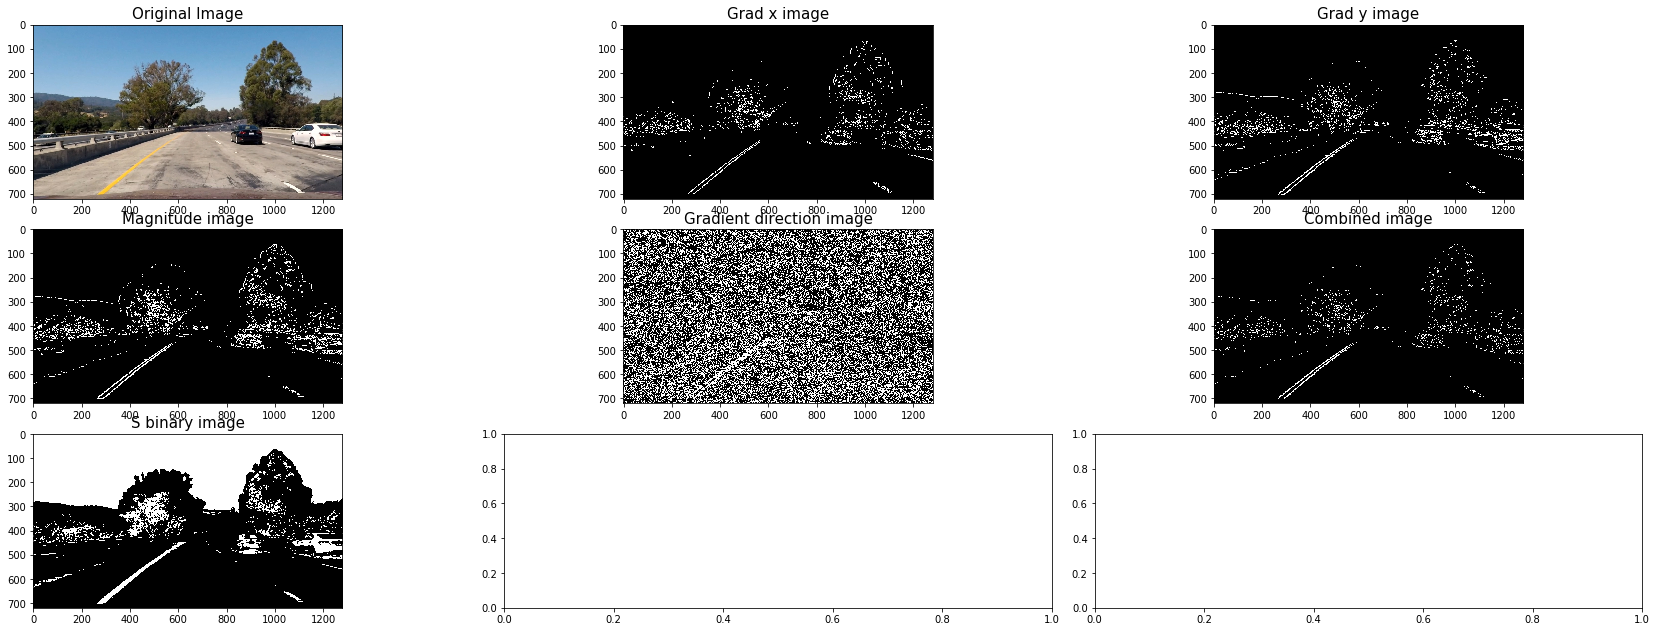

In [28]:
# Perform combined thresholding


# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Read in an image
img = mpimg.imread('test_images/test1.jpg')

# Perform image undistortion
image = cv2.undistort(img, mtx, dist, None, mtx)

# Convert image to chosen colour spaces
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
HLS = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
S = HLS[:,:,2]

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(30,100))
grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(30, 100))
mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0.7, 1.3))
s_binary = binary_S(S,(90,255))
gradx = abs_sobel_thresh(S, orient='x', sobel_kernel=ksize, thresh=(30,100))
grady = abs_sobel_thresh(S, orient='y', sobel_kernel=ksize, thresh=(30,100))
mag_binary = mag_thresh(S, sobel_kernel=ksize, mag_thresh=(30,100))
dir_binary = dir_threshold(S, sobel_kernel=ksize, thresh=(0.7, 1.3))

# Combine thresholding functions
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Plot the result
f, axes = plt.subplots(3, 3, figsize=(24, 9))
f.tight_layout()
axes[0,0].imshow(image)
axes[0,0].set_title('Original Image', fontsize=15)
axes[0,1].imshow(gradx, cmap='gray')
axes[0,1].set_title('Grad x image', fontsize=15)
axes[0,2].imshow(grady,cmap='gray')
axes[0,2].set_title('Grad y image',fontsize=15)
axes[1,0].imshow(mag_binary,cmap='gray')
axes[1,0].set_title('Magnitude image',fontsize=15)
axes[1,1].imshow(dir_binary,cmap='gray')
axes[1,1].set_title('Gradient direction image',fontsize=15)
axes[1,2].imshow(combined,cmap='gray')
axes[1,2].set_title('Combined image',fontsize=15)
axes[2,0].imshow(s_binary,cmap='gray')
axes[2,0].set_title('S binary image',fontsize=15)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

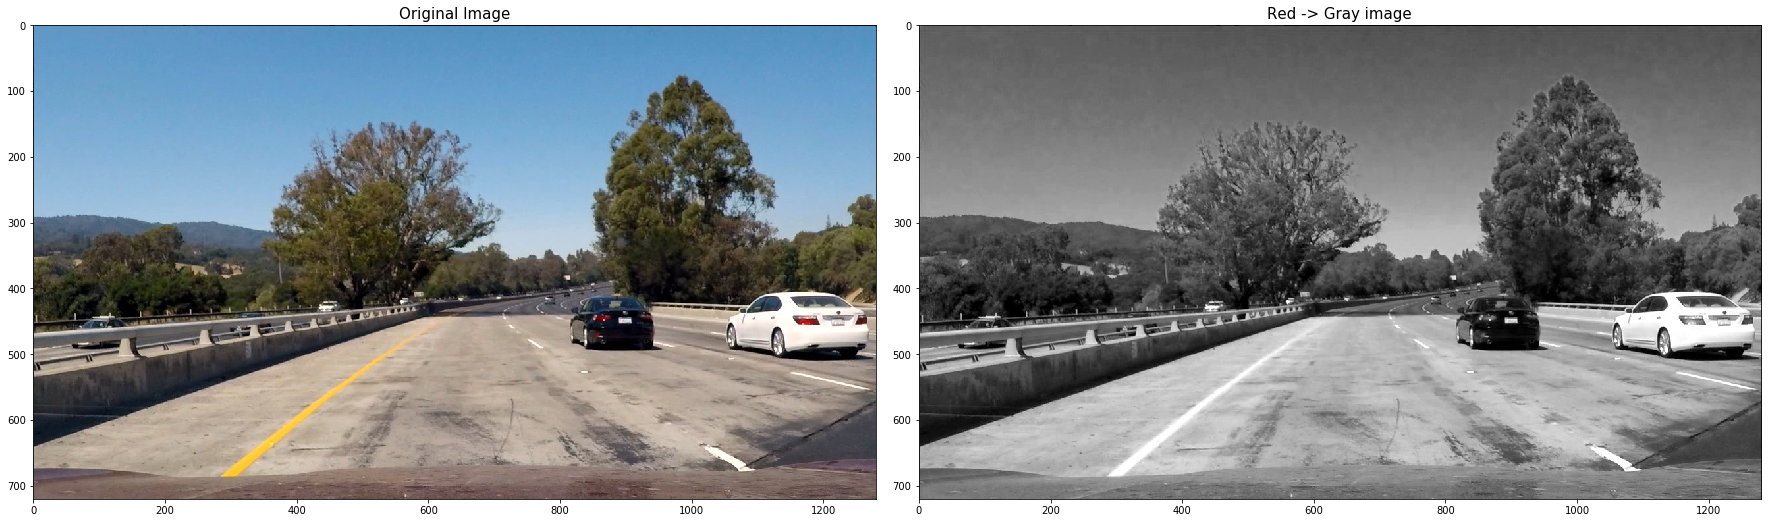

1.5707963267948966


In [29]:
# Read in an image
img = mpimg.imread('test_images/test1.jpg')

R_gray = img[:,:,0]
#R_gray = cv2.cvtColor(R,cv2.COLOR_RGB2GRAY)


# Plot the result
f, axes = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
axes[0].imshow(img)
axes[0].set_title('Original Image', fontsize=15)
axes[1].imshow(R_gray,cmap='gray')
axes[1].set_title('Red -> Gray image',fontsize=15)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

print(np.pi/2)